# Define BeerLaNet Module

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BeerLaNet(nn.Module):
    def __init__(self, r, c=3, learn_S_init=False, calc_tau=True):
        r"""
        A layer to perform color normalization based on a sparse, low-rank non-negative
        matrix factorization model of the form:

        min_{x_0,S,D} 1/2|X + S*D^T - x_0*1^T|_F^2
        + \lambda \sum_{i=1}^r |s_i|_2 (\gamma |d_i|_1 + |d_i|_2)
        s.t. S >= 0, D >= 0

        This is accomplished through alternating updates of (x_0, S, D).

        Parameters
        ----------
        r : int
            Number of columns in S and D (rank of factorization).
        c : int
            Number of color channels (usually 3 for RGB).
        learn_S_init : bool
            If True, S initialization is a learnable parameter.
        calc_tau : bool
            If True, tau step size is calculated from norms. Otherwise, it is learnable.
        """
        super(BeerLaNet, self).__init__()
        self.r = r
        self.c = c
        self.calc_tau = calc_tau

        self.gamma = nn.Parameter(torch.rand(1) * 1e-5)
        self.lam   = nn.Parameter(torch.rand(1) * 1e-5)

        if not calc_tau:
            self.tau = nn.Parameter(torch.rand(1) * 1e-5)

        if learn_S_init:
            self.S_init = nn.Parameter(torch.rand(self.c, self.r))
            with torch.no_grad():
                self.S_init.data = self.S_init.data / self._S_norm(self.S_init.data)
        else:
            self.S_init = None

    def forward(self, X, S=None, D=None, n_iter=1, unit_norm_S=True):
        r"""
        Perform update iterations for the matrix factorization color normalization model.

        Parameters
        ----------
        X : torch.Tensor [n,c,H,W]
            Input images. n=batch size, c=channels, (H,W)=height,width.
        S : torch.Tensor [c,r], optional
            Initial spectra. Required if learn_S_init=False.
        D : torch.Tensor [n,r,H,W], optional
            Initial density maps. Default is zero.
        n_iter : int
            Number of update iterations.
        unit_norm_S : bool
            If True, normalize S columns to unit norm.

        Returns
        -------
        x_0 : torch.Tensor [c]
            Background intensity.
        S : torch.Tensor [c,r]
            Spectrum matrix.
        D : torch.Tensor [n,r,H,W]
            Optical density maps.
        """
        n, c_in, H, W = X.shape
        assert c_in == self.c
        p = H * W

        # reshape X → [n,c,p]
        X = X.view(-1, self.c, p)

        if S is None:
            S = self.S_init.clone().to(X.device)
        if D is None:
            Dt = torch.zeros(n, self.r, p, device=X.device)  # D^T
        else:
            Dt = D.view(-1, self.r, p)

        with torch.no_grad():
            self.gamma.data = torch.abs(self.gamma.data)
            self.lam.data   = torch.abs(self.lam.data)
            if not self.calc_tau:
                self.tau.data = torch.abs(self.tau.data)

        # main loop
        for _ in range(n_iter):
            SDt = S @ Dt  # [n,c,p]

            # update x_0
            x_0 = torch.mean(X + SDt, dim=2, keepdims=True)

            # --- update D ---
            tau_D = (1.0 / torch.linalg.matrix_norm(S, ord='fro')**2
                     if self.calc_tau else self.tau)
            Dt += -tau_D * (S.T @ SDt + S.T @ X - S.T @ x_0)

            S_nrm = self._S_norm(S).view(1, self.r, 1)
            Dt = F.relu(Dt - self.lam * self.gamma * tau_D * S_nrm)
            Dt_L2 = self._Dt_Lp(Dt, 2)
            scl = F.relu(Dt_L2 - self.lam * tau_D * S_nrm)
            scl = scl / (Dt_L2 + 1e-10)
            Dt = Dt * scl

            # --- update S ---
            SDt = S @ Dt
            x_0 = torch.mean(X + SDt, dim=2, keepdims=True)
            Dt_sum = Dt.sum(dim=2, keepdim=True)
            tau_S = (1.0 / torch.mean(torch.linalg.matrix_norm(Dt, ord='fro')**2)
                     if self.calc_tau else self.tau)
            S_grad = S - tau_S * torch.mean(
                SDt @ Dt.permute(0, 2, 1) +
                X @ Dt.permute(0, 2, 1) -
                x_0 @ Dt_sum.permute(0, 2, 1),
                dim=0
            )

            Dt_nrm = self._Dt_norm(Dt).mean(dim=0)
            S_nrm = self._S_norm(S_grad)
            scl_S = F.relu(S_nrm - self.lam * tau_S * Dt_nrm.T)
            scl_S = scl_S / (S_nrm + 1e-10)
            S = S_grad * scl_S

            if unit_norm_S:
                S_nrm = self._S_norm(S)
                S = S / (S_nrm + 1e-10)
                Dt = Dt * (S_nrm.view(1, self.r, 1) + 1e-10)

        return x_0, S, Dt.view(n, self.r, H, W)

    def _S_norm(self, S):
        """Return L2 norm of S columns [1,r]."""
        return torch.linalg.vector_norm(S, ord=2, dim=0, keepdim=True)

    def _Dt_Lp(self, Dt, nrm_ord):
        """Return Lp norm of D^T rows [n,r,1]."""
        return torch.linalg.vector_norm(Dt, ord=nrm_ord, dim=2, keepdim=True)

    def _Dt_norm(self, Dt):
        """Return gamma*||D||_1 + ||D||_2 for D^T rows [n,r,1]."""
        return self.gamma * self._Dt_Lp(Dt, 1) + self._Dt_Lp(Dt, 2)


# Load demo image


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


x0: torch.Size([1, 3, 1])
S: torch.Size([3, 6])
D: torch.Size([1, 6, 149, 141])


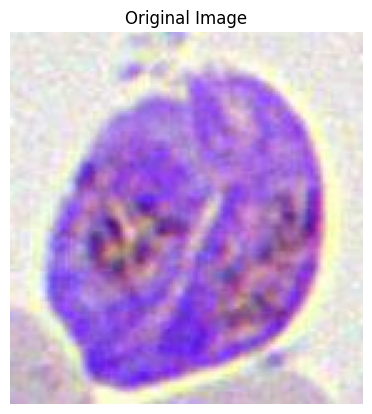

In [15]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

# r defines the output channels of decomposition results
r = 6
model = BeerLaNet(r=r, c=3, learn_S_init=True, calc_tau=True)

# 1. Load image from same folder as this notebook/script
folder_paht = "/content/drive/MyDrive/BeerLaNet"
img_name = "2_x0y179_p_1.jpg"  # make sure this matches the file name exactly
img_path = folder_paht + "/" + img_name
img = Image.open(img_path).convert("RGB")

# 2. Plot the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

# Apply decomposition and visualize all the D channels

## Note:
This demo runs BeerLaNet with **randomly initialized parameters** (λ, γ, τ, and S_init).

In practice, ColorNorm is meant to be trained jointly with a downstream task
(e.g., classification or segmentation) so that its parameters adapt and learn meaningful decompositions useful for the task.

x0: torch.Size([1, 3, 1])
S: torch.Size([3, 6])
D: torch.Size([1, 6, 149, 141])


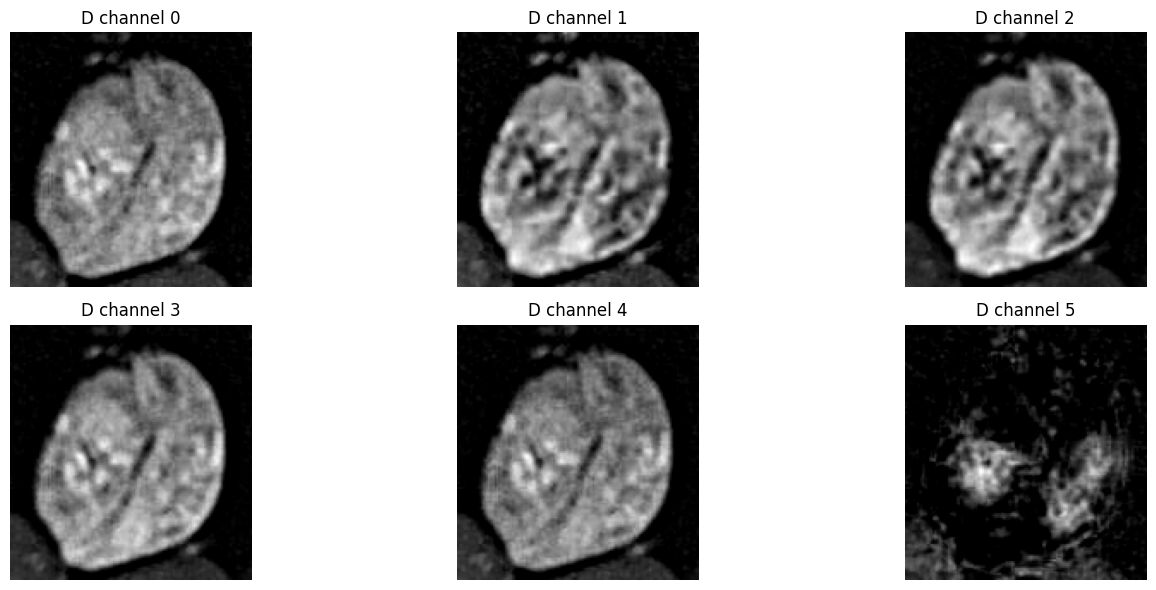

In [16]:

# 3. Convert to tensor and normalize to [0,1]
transform = T.Compose([
    T.ToTensor()  # [C,H,W], values in [0,1]
])
X = transform(img).unsqueeze(0)  # [1,3,H,W]

# 4. Run BeerLaNet decomposition for 5 iterations
x0, S, D = model(X, n_iter=5)

print("x0:", x0.shape)  # [3,1]
print("S:", S.shape)    # [3,r]
print("D:", D.shape)    # [1,r,H,W]

# 5. Visualize each channel of D
n, r, H, W = D.shape
D = D.squeeze(0)  # [r,H,W]

fig, axes = plt.subplots(2, r//2, figsize=(15, 6))
axes = axes.flatten()

for i in range(r):
    channel_img = D[i].detach().cpu().numpy()
    axes[i].imshow(channel_img, cmap="gray")
    axes[i].set_title(f"D channel {i+1}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()